# 🧭 TP2 — Exploratory Data Analysis (EDA)

### 🎯 Objective

The goal of this TP is to perform an **Exploratory Data Analysis (EDA)** on the different datasets used in our project.  
This step aims to **understand the structure, quality, and relationships within the data** before moving on to more advanced analysis or modeling.

---

### 🧩 Steps of the Analysis

1. **Data Loading**  
   - Import the various datasets (CSV files, shapefiles, etc.).  
   - Check the structure and data types.

2. **Descriptive Analysis**  
   - Compute basic statistics: mean, median, mode, min, max, and standard deviation.  
   - Check for missing values and duplicates.

3. **Univariate Analysis**  
   - Study the distribution of variables using histograms and boxplots.  
   - Detect outliers and unusual values.

4. **Bivariate / Multivariate Analysis**  
   - Explore relationships between variables using scatter plots and correlation matrices.

5. **Spatial Analysis (if applicable)**  
   - Visualize geospatial data using `GeoPandas`.  
   - Overlay spatial layers (e.g., fires, vegetation, administrative boundaries).

6. **Summary of Findings**  
   - Highlight key patterns, trends, and anomalies.  
   - Prepare the data for the next steps of the project.

---

### 🛠️ Code Organization

To keep the analysis clean and modular, all helper functions for EDA are defined in an external file named **`eda_utils.py`**.  
This file contains reusable functions for:
- Descriptive statistics  
- Visualizations (histograms, boxplots, scatter plots, heatmaps)  
- Spatial plots (for geospatial datasets)

These functions are imported and used throughout this notebook to perform the EDA on multiple datasets.

---

### 📦 Main Libraries

| Category | Library | Description |
|-----------|----------|-------------|
| Data manipulation | `pandas`, `numpy` | Data loading, cleaning, and statistical analysis |
| Visualization | `matplotlib`, `seaborn` | Graphical exploration and plotting |
| Geospatial data | `geopandas`, `contextily` | Reading and visualizing shapefiles |
| Custom tools | `eda_utils.py` | User-defined functions for EDA |

---

### 🧠 Expected Outcome

By the end of this TP, we will have:
- A clear understanding of the structure and quality of our datasets  
- Complete descriptive statistics  
- Relevant visualizations to interpret variable relationships  
- A solid foundation for further analysis and modeling


In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
import os
from rasterio.enums import Resampling # ✅ Import Resampling
from shapely.geometry import Point
import numpy as np
from shapely.ops import unary_union


from scripts.explore_raster import show_raster , describe_raster
from scripts.clip_raster_with_shape import clip_raster_with_shape
from scripts.plots import plot_fire_map
from scripts.concat_shapefiles import concat_shapefiles
from scripts.explore_shapefiles import describe_shapefile, show_landcover_separated




In [2]:
alg_tun_shp = gpd.read_file("../data/shapefiles/combined/alg_tun.shp")
alg_tun_gpd = gpd.GeoDataFrame(geometry=[unary_union(alg_tun_shp.geometry)],
                                crs=alg_tun_shp.crs)

tmax_paths = sorted(glob.glob("../data/climate_dataset/5min/max/*.tif"))
tmin_paths = sorted(glob.glob("../data/climate_dataset/5min/min/*.tif"))
tprec_paths = sorted(glob.glob("../data/climate_dataset/5min/prec/*.tif"))

alg_tun_shp_landcvr = concat_shapefiles(
    "../data/land_dataset/algeria/dza_gc_adg.shp",
    "../data/land_dataset/tunisia/tun_gc_adg.shp"
)

fire_alg_path = "../data/fire_dataset/viirs-jpss1_2024_Algeria.csv"
fire_tun_path = "../data/fire_dataset/viirs-jpss1_2024_Tunisia.csv"
fire_alg = pd.read_csv(fire_alg_path)
fire_tun = pd.read_csv(fire_tun_path)
fire_df = pd.concat([fire_alg, fire_tun], ignore_index=True)



In [3]:
from eda_scripts.eda_utils import (
    describe_dataset,
    check_missing_values,
    plot_missing_values,
    summary_stats,
    report_skew_kurtosis,
    plot_variable_distribution,
    plot_boxplot,
    plot_scatter,
    plot_correlation_matrix,
    plot_pairplot,
    compare_distributions,
    detect_outliers_iqr,
    plot_geodata,
    summarize_geodata,
    plot_spatial_heatmap,
    data_quality_report,
    plot_qq,
    plot_categorical_distribution,
    plot_multiple_distributions
)

from shapely.geometry import Point
import geopandas as gpd
import pandas as pd


from scripts.raster_to_df import raster_to_dataframe_filter_background , raster_to_dataframe
from scripts.clip_raster_with_shape import clip_raster_with_shape



## ☁️ EDA for Climate Data ☁️

### 🌡️ Climate Data Preparation
We clip the **temperature and precipitation rasters** to the study area (Algeria and Tunisia),  
convert each raster to a **DataFrame** containing pixel values and coordinates,  
then **merge** them into a single dataset with columns: `x`, `y`, `tmax`, `tmin`, and `tprec`.


In [ ]:
# === 🌍 CLIMATE DATA PREPARATION ===

# --- 1️ Clip Tmax raster to Algeria and Tunisia ---
tmax_image, tmax_transform, tmax_meta = clip_raster_with_shape(
    tmax_paths[0],
    alg_tun_gpd
)

# Convert Tmax raster to DataFrame
tmax_df = raster_to_dataframe_filter_background(
    out_image=tmax_image,
    out_transform=tmax_transform,
    shape_input=alg_tun_shp,
    value_name='tmax'
)

# --- 2️ Clip Tmin raster to Algeria and Tunisia ---
tmin_image, tmin_transform, tmin_meta = clip_raster_with_shape(
    tmin_paths[0],
    alg_tun_gpd
)

# Convert Tmin raster to DataFrame
tmin_df = raster_to_dataframe_filter_background(
    out_image=tmin_image,
    out_transform=tmin_transform,
    shape_input=alg_tun_shp,
    value_name='tmin'
)

# --- 3️ Clip Tprec raster to Algeria and Tunisia ---
tprec_image, tprec_transform, tprec_meta = clip_raster_with_shape(
    tprec_paths[0],
    alg_tun_gpd
)

# Convert Tprec raster to DataFrame
tprec_df = raster_to_dataframe_filter_background(
    out_image=tprec_image,
    out_transform=tprec_transform,
    shape_input=alg_tun_shp,
    value_name='tprec'
)

# --- 4️ Merge all DataFrames on (x, y) ---
climat_df = (
    tmax_df
    .merge(tmin_df, on=["x", "y"], how="outer")
    .merge(tprec_df, on=["x", "y"], how="outer")
)

# Reorder columns
climat_df = climat_df[["x", "y", "tmax", "tmin", "tprec"]]

# ✅ Display the first few rows
print("=== 🧾 Dataset Preview ===")
climat_df.head()


### 🔍 Missing Data Analysis  
Check and visualize missing values in the climate dataset to ensure data completeness.


In [ ]:
# Describe only temperature-related columns
check_missing_values(climat_df)
plot_missing_values(climat_df)

### 📊 Descriptive Statistics of Temperature Variables  
We examine key statistical characteristics of the climate dataset, focusing on the main temperature indicators:  
- **tmax** → average maximum temperature  
- **tmin** → average minimum temperature  
- **tprec** → total precipitation  

This step displays a **preview of the dataset**, provides **general information** (data types, non-null counts, memory usage),  
and summarizes **descriptive statistics** such as mean, median, quartiles, and standard deviation for each variable.


In [ ]:
describe_dataset(climat_df, cols=["tmax", "tmin", "tprec"])


### 📈 Summary Statistics by Variable  
We compute and display detailed **summary statistics** for each climate variable individually:  

- **tmin** → average minimum temperature  
- **tmax** → average maximum temperature  
- **tprec** → total precipitation  

This analysis provides insights into each variable’s **central tendency** (mean, median), **dispersion** (standard deviation), and **distribution shape** (skewness, kurtosis).  
It helps assess data quality, detect outliers, and understand climate variability within the study area.


In [ ]:
print(summary_stats(climat_df, ["tmin"]))
print(summary_stats(climat_df, ["tmax"]))
print(summary_stats(climat_df, ["tprec"]))

## Distribution and Outlier Analysis

### 🌦️ Variable Distributions  
Visualize the distribution of each climate variable — **tmax**, **tmin**, and **tprec** — using histograms with KDE curves.  
These plots reveal how values are spread across the study area, helping identify the overall shape of each distribution, potential outliers, and differences in variability between temperature and precipitation.


In [ ]:
plot_variable_distribution(climat_df, "tmax")
plot_variable_distribution(climat_df, "tmin")
plot_variable_distribution(climat_df, "tprec")

### 📦 Boxplot Analysis  
Display boxplots for the climate variables **tmax**, **tmin**, and **tprec** to examine their value ranges and detect potential outliers.  
Boxplots provide a clear summary of the data’s **median**, **quartiles**, and **extreme values**, offering insight into variability and skewness across the study area.


In [ ]:
plot_boxplot(climat_df, "tmax")
plot_boxplot(climat_df, "tmin")
plot_boxplot(climat_df, "tprec")

### 🚨 Outlier Detection (IQR Method)  
Identify outliers in the climate variables **tmax**, **tmin**, and **tprec** using the **Interquartile Range (IQR)** method.  
This technique flags values that lie significantly above or below the normal range (beyond 1.5×IQR), helping to detect unusual or extreme climate observations in the dataset.


In [ ]:
outliers_tmax = detect_outliers_iqr(climat_df, "tmax")
outliers_tmin = detect_outliers_iqr(climat_df, "tmin")
outliers_tprec = detect_outliers_iqr(climat_df, "tprec")

### 📈 Skewness and Kurtosis Analysis

We calculate **skewness** and **kurtosis** for each temperature-related variable (`tmax`, `tmin`, and `tprec`) using the `report_skew_kurtosis` function.  
This helps summarize the **shape characteristics** of the data distributions — skewness measures the asymmetry, while kurtosis measures the peakedness or flatness of the distribution.


In [ ]:
report_skew_kurtosis(climat_df, ["tmax"])
report_skew_kurtosis(climat_df, ["tmin"])
report_skew_kurtosis(climat_df, ["tprec"])

## 🧪 Normality Check  

### 📊 Q–Q Plots  

We use **Quantile–Quantile (Q–Q) plots** to visually assess whether each variable follows a **normal distribution**.  
These plots compare the distribution of the data to a theoretical normal distribution — if the data points fall approximately along the diagonal line, the variable is likely normally distributed.  

The Q–Q plots are generated for:  
- 🌡️ **tmax** (maximum temperature)  
- 🌡️ **tmin** (minimum temperature)  
- ☔ **tprec** (precipitation)


In [ ]:
plot_qq(climat_df, "tmax")
plot_qq(climat_df, "tmin")
plot_qq(climat_df, "tprec")

## 🔗 Bivariate Analysis  

### 📈 Correlation and Pairwise Relationships  

In this section, we explore the relationships between the temperature-related variables by examining their **correlation matrix** and **pairwise plots**.  
These analyses help visualize how variables are related to each other and reveal potential linear or non-linear associations.


In [ ]:
plot_correlation_matrix(climat_df, cols=["tmax", "tmin", "tprec"])
plot_pairplot(climat_df, columns=["tmax", "tmin", "tprec"])

### Temporal Evolution (Monthly Means)

In [ ]:
means_tmax = []
labels = []
for path in tmax_paths:
    arr, _, _ = clip_raster_with_shape(path, alg_tun_gpd)
    arr = arr.flatten()
    arr = arr[~np.isnan(arr)]
    means_tmax.append(arr.mean())
    labels.append(path.split("/")[-1][:7])

plt.figure(figsize=(12, 5))
plt.plot(labels, means_tmax, marker="o")
plt.xticks(rotation=45)
plt.title("Mean Tmax Evolution Over Time")
plt.xlabel("Month")
plt.ylabel("Average Tmax (°C)")
plt.grid()
plt.show()


In [ ]:
means_tmax = []
labels = []
for path in tmin_paths:
    arr, _, _ = clip_raster_with_shape(path, alg_tun_gpd)
    arr = arr.flatten()
    arr = arr[~np.isnan(arr)]
    means_tmax.append(arr.mean())
    labels.append(path.split("/")[-1][:7])

plt.figure(figsize=(12, 5))
plt.plot(labels, means_tmax, marker="o")
plt.xticks(rotation=45)
plt.title("Mean Tmax Evolution Over Time")
plt.xlabel("Month")
plt.ylabel("Average Tmax (°C)")
plt.grid()
plt.show()


In [ ]:
means_tmax = []
labels = []
for path in tprec_paths:
    arr, _, _ = clip_raster_with_shape(path, alg_tun_gpd)
    arr = arr.flatten()
    arr = arr[~np.isnan(arr)]
    means_tmax.append(arr.mean())
    labels.append(path.split("/")[-1][:7])

plt.figure(figsize=(12, 5))
plt.plot(labels, means_tmax, marker="o")
plt.xticks(rotation=45)
plt.title("Mean Tmax Evolution Over Time")
plt.xlabel("Month")
plt.ylabel("Average Tmax (°C)")
plt.grid()
plt.show()


## 🏔️ EDA for Elevation Data 🏔️

### General Dataset Overview

In [ ]:
elevation_file = "../data/elevation_dataset/be15_grd/w001001.adf"
elevation_image, elevation_transform, elevation_meta = clip_raster_with_shape(
    elevation_file,
    alg_tun_gpd
)

elevation_df = raster_to_dataframe(elevation_image, elevation_transform) 

describe_dataset(elevation_df)

### Check for Missing Values

In [ ]:
check_missing_values(elevation_df)

### Visualize Missing Values

In [ ]:
plot_missing_values(elevation_df)

### Statistics and Data Quality Report

In [ ]:
data_quality_report(elevation_df)
print(summary_stats(elevation_df, ["elevation"]))

### Distribution, Outlier & Relationship Visuals

Histograms

In [ ]:
plot_variable_distribution(elevation_df, "elevation")

Boxplots

In [ ]:
plot_boxplot(elevation_df, "elevation")

Outlier Detection

In [ ]:
detect_outliers_iqr(elevation_df, "elevation")

Skewness and Kurtosis

In [ ]:

report_skew_kurtosis(elevation_df, ["elevation"])


### Pairplot

In [ ]:
plot_correlation_matrix(elevation_df, cols=["x", "elevation"])
plot_correlation_matrix(elevation_df, cols=["y", "elevation"])

plot_pairplot(elevation_df, columns=["x", "elevation"])
plot_pairplot(elevation_df, columns=["y", "elevation"])

## 🟩 EDA for Land Data 🟩

###  General Dataset Overview

In [ ]:
summarize_geodata(alg_tun_shp_landcvr)
describe_dataset(alg_tun_shp_landcvr)

### Check for Missing Values

In [ ]:
missing_landvr = check_missing_values(alg_tun_shp_landcvr)

### Visualize Missing Values

In [ ]:
plot_missing_values(alg_tun_shp_landcvr)

### Statistics and Data Quality Report

In [ ]:
report = data_quality_report(alg_tun_shp_landcvr)

### Distribution, Outlier & Categorical Visuals

Histograms/Categorical

In [ ]:
plot_categorical_distribution(alg_tun_shp_landcvr, "GRIDCODE", top_n=15)

In [ ]:
plot_categorical_distribution(alg_tun_shp_landcvr, "AREA_M2", top_n=15)

Boxplots and Outlier Detection

In [ ]:
plot_boxplot(alg_tun_shp_landcvr, "AREA")
detect_outliers_iqr(alg_tun_shp_landcvr, "AREA")


Skewness and Kurtosis

In [ ]:
report_skew_kurtosis(alg_tun_shp_landcvr, ["AREA"])

Relationships

In [ ]:
# plot_scatter(alg_tun_shp_landcvr, "shape_area", "LCCS_CODE")

### Q–Q Plot

In [ ]:
plot_qq(alg_tun_shp_landcvr, "AREA")

In [ ]:
# 🧹 Dropping less important columns with high missing values (if they exist)
cols_to_drop = ["AREA_M2", "LCCCode", "AREA", "LCCCODE"]

# Drop only columns that are actually present in the DataFrame
alg_tun_shp_landcvr = alg_tun_shp_landcvr.drop(
    columns=[col for col in cols_to_drop if col in alg_tun_shp_landcvr.columns],
    errors="ignore"
)

# Display the cleaned DataFrame
alg_tun_shp_landcvr.head()


## 🔥 EDA for Fire Data 🔥

In [8]:


fire_alg_path = "../data/fire_dataset/viirs-jpss1_2024_Algeria.csv"
fire_tun_path = "../data/fire_dataset/viirs-jpss1_2024_Tunisia.csv"

fire_alg = pd.read_csv(fire_alg_path, na_values=[" ", "", "NaN", "nan", "NULL", "null"])
fire_tun = pd.read_csv(fire_tun_path, na_values=[" ", "", "NaN", "nan", "NULL", "null"])

fire_df = pd.concat([fire_alg, fire_tun], ignore_index=True)
fire_df.drop(columns=['version'], inplace=True)

print(f"✅ Combined fire data loaded: {len(fire_df)} rows")


✅ Combined fire data loaded: 90250 rows


### General dataset overview

In [9]:
describe_dataset(fire_df)

=== 🧾 Dataset Preview ===


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,272.08,1.58,N,2



=== ℹ️ General Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90250 entries, 0 to 90249
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    90250 non-null  float64
 1   longitude   90250 non-null  float64
 2   bright_ti4  90250 non-null  float64
 3   scan        90250 non-null  float64
 4   track       90250 non-null  float64
 5   acq_date    90250 non-null  object 
 6   acq_time    90250 non-null  int64  
 7   satellite   90250 non-null  object 
 8   instrument  90250 non-null  object 
 9   confidence  90250 non-null  object 
 10  bright_ti5  90250 non-null  float64
 11  frp         90250 non-null  float64
 12  daynight    90250 non-null  object 
 13  type        90250 non-null  int64  
dtypes: float64(7), int64(2), object(5)
memory usage: 9.6+ MB
None

=== 📊 Descriptive Statistics ===


,bright_ti4,scan,track,acq_time,bright_ti5,frp,type
count,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000
mean,321.091793,0.475991,0.515446,380.331623,291.726092,3.447776,1.690936
std,18.205551,0.101596,0.126508,480.710563,11.700269,5.222111,0.735207
min,240.170000,0.320000,0.360000,0.000000,244.790000,0.060000,0.000000
25%,305.380000,0.400000,0.390000,59.000000,282.900000,1.150000,2.000000
50%,316.710000,0.450000,0.490000,140.000000,290.790000,2.060000,2.000000
75%,337.400000,0.540000,0.620000,232.000000,298.100000,3.920000,2.000000
max,367.000000,0.800000,0.780000,1410.000000,355.420000,251.890000,3.000000


### Check for missing values

✅ No missing values detected.


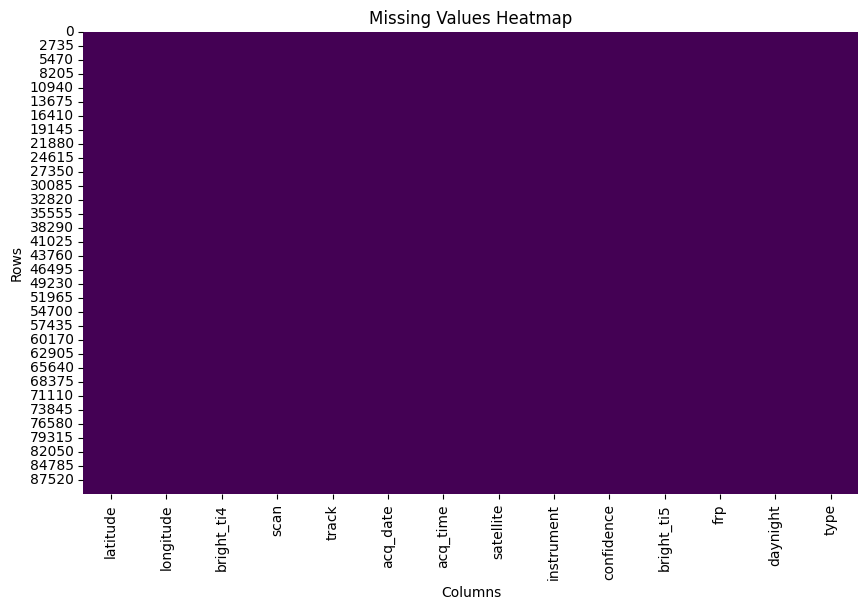

In [10]:
check_missing_values(fire_df)
plot_missing_values(fire_df)

### Statistics and Data Quality Report

In [12]:
numeric_cols = ["bright_ti4", "frp"]  # use dataset columns
print(summary_stats(fire_df, numeric_cols))
report_skew_kurtosis(fire_df, numeric_cols)
report = data_quality_report(fire_df)

          bright_ti4           frp
mean      321.091793      3.447776
median    316.710000      2.060000
std        18.205551      5.222111
min       240.170000      0.060000
max       367.000000    251.890000
count   90250.000000  90250.000000
bright_ti4: skew=0.44, kurtosis=-0.93
frp: skew=11.72, kurtosis=301.67
=== Data Quality Report ===


,Data Type,Missing (%),Unique Values,Zeros (%),Negative Values (%)
acq_date,object,0.0,364,0.000000,NaN
acq_time,int64,0.0,348,0.001108,0.000000
bright_ti4,float64,0.0,6189,0.000000,0.000000
bright_ti5,float64,0.0,6180,0.000000,0.000000
confidence,object,0.0,3,0.000000,NaN
daynight,object,0.0,2,0.000000,NaN
frp,float64,0.0,2565,0.000000,0.000000
instrument,object,0.0,1,0.000000,NaN
latitude,float64,0.0,54957,0.000000,0.000000
longitude,float64,0.0,56922,0.000000,5.525762


### Distribution, Outlier & Relationship Visuals

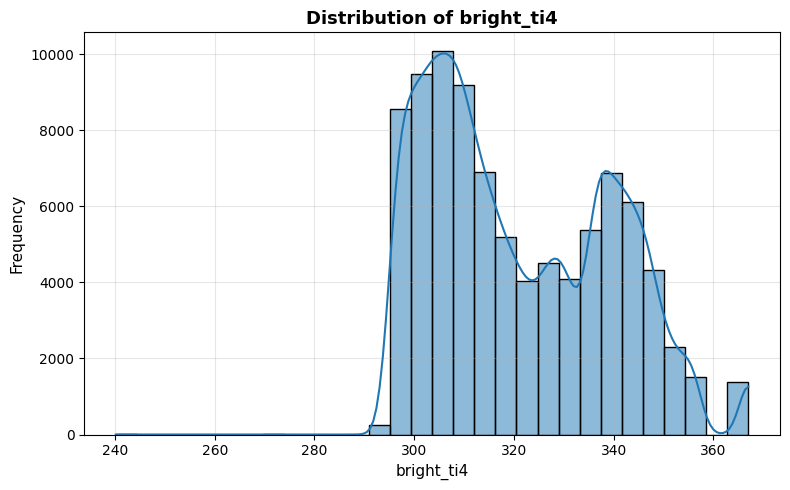

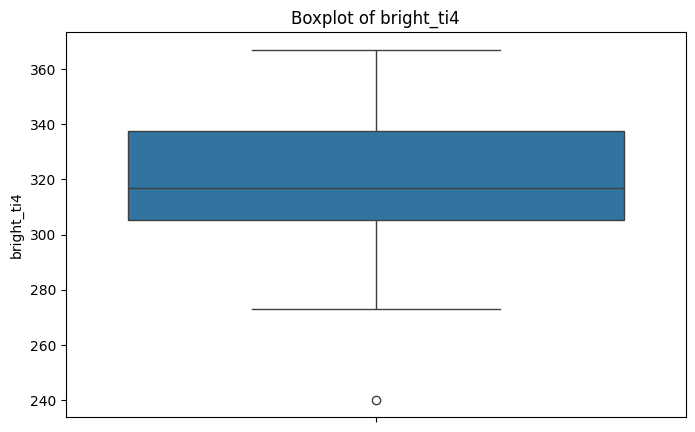

=== Outlier Detection Report for 'bright_ti4' ===
Q1 (25th percentile): 305.3800
Q2 (Median):          316.7100
Q3 (75th percentile): 337.4000
IQR (Q3 - Q1):        32.0200
Lower bound:          257.3500
Upper bound:          385.4300
Number of outliers:   1 / 90250 rows


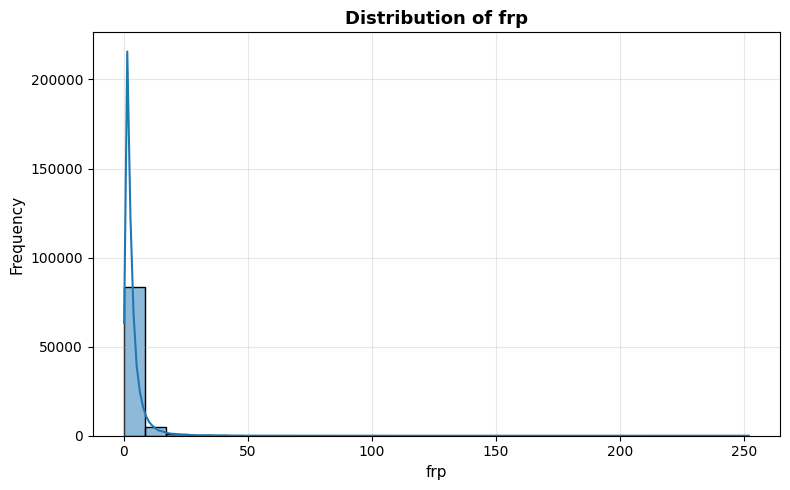

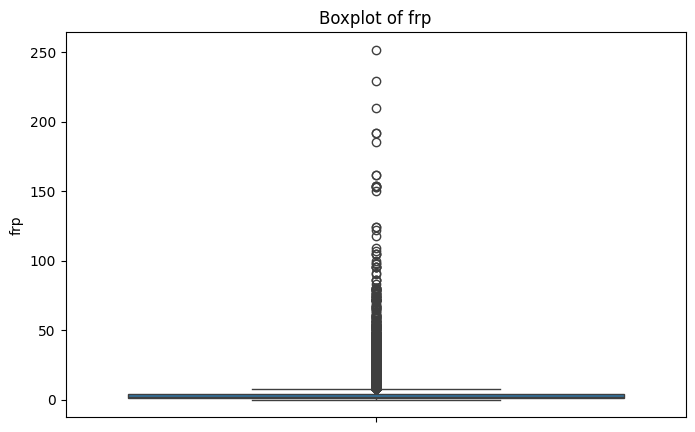

=== Outlier Detection Report for 'frp' ===
Q1 (25th percentile): 1.1500
Q2 (Median):          2.0600
Q3 (75th percentile): 3.9200
IQR (Q3 - Q1):        2.7700
Lower bound:          -3.0050
Upper bound:          8.0750
Number of outliers:   7210 / 90250 rows


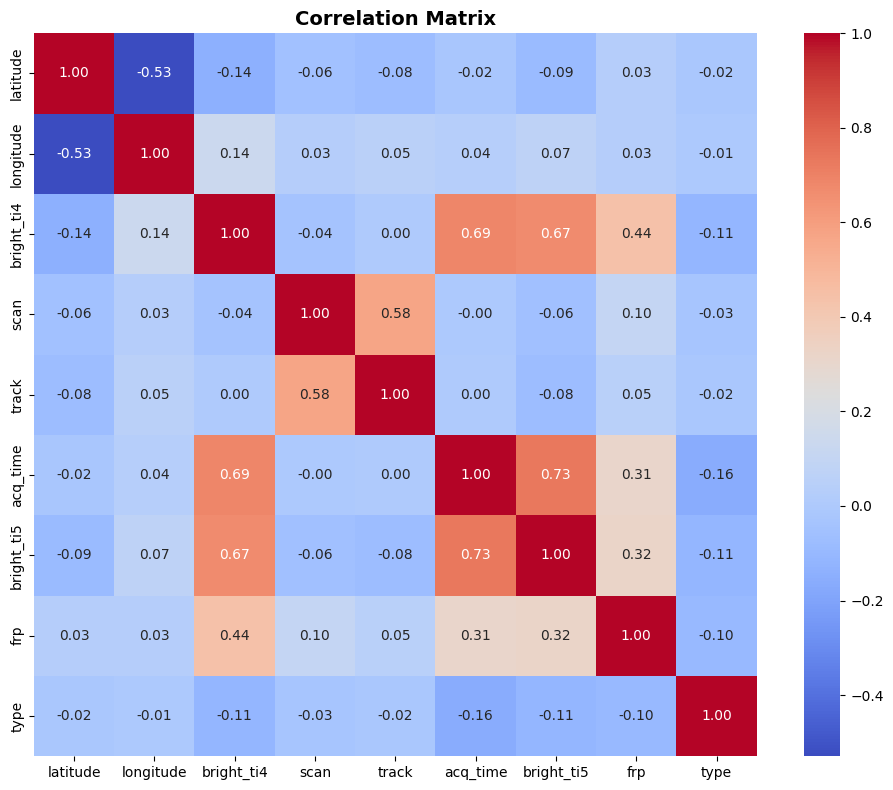

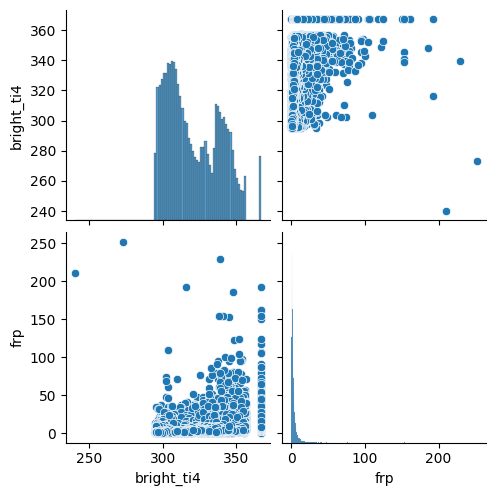

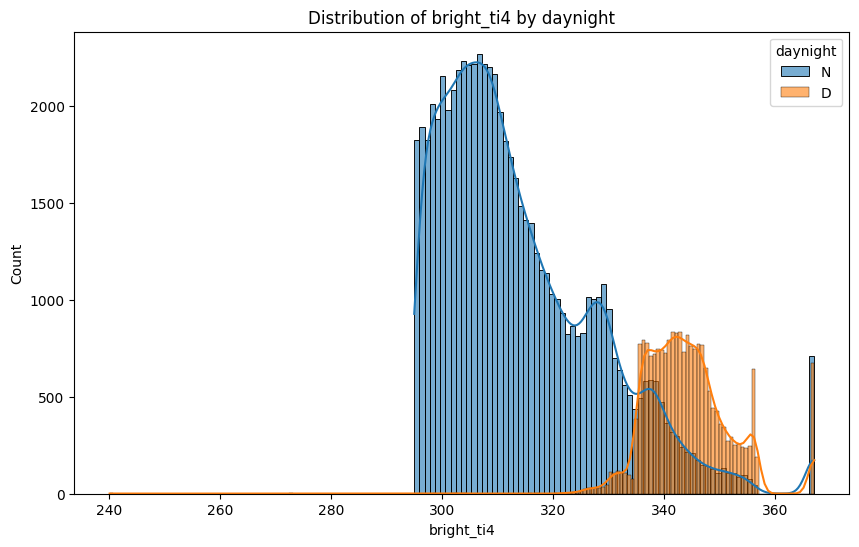

In [13]:
plot_variable_distribution(fire_df, "bright_ti4")
plot_boxplot(fire_df, "bright_ti4")
detect_outliers_iqr(fire_df, "bright_ti4")
#visualize_outliers(fire_df, "bright_ti4")

plot_variable_distribution(fire_df, "frp")
plot_boxplot(fire_df, "frp")
detect_outliers_iqr(fire_df, "frp")
#visualize_outliers(fire_df, "frp")

plot_correlation_matrix(fire_df)
plot_pairplot(fire_df, columns=["bright_ti4", "frp", "confidence"])
compare_distributions(fire_df, "bright_ti4", by="daynight")

### Q-Q Plot

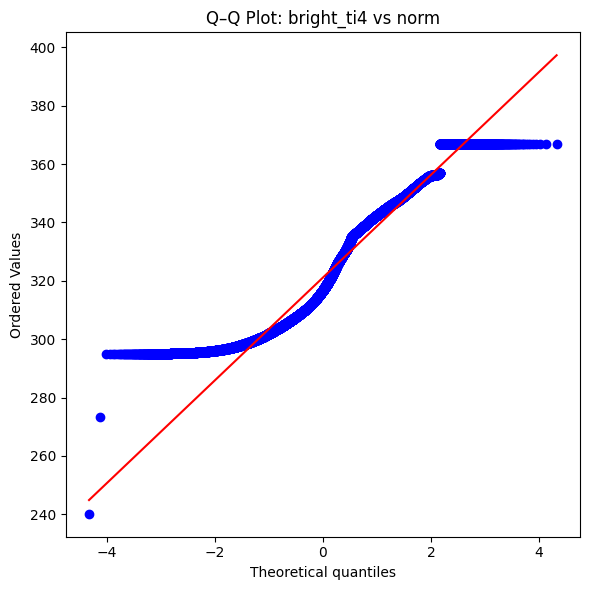

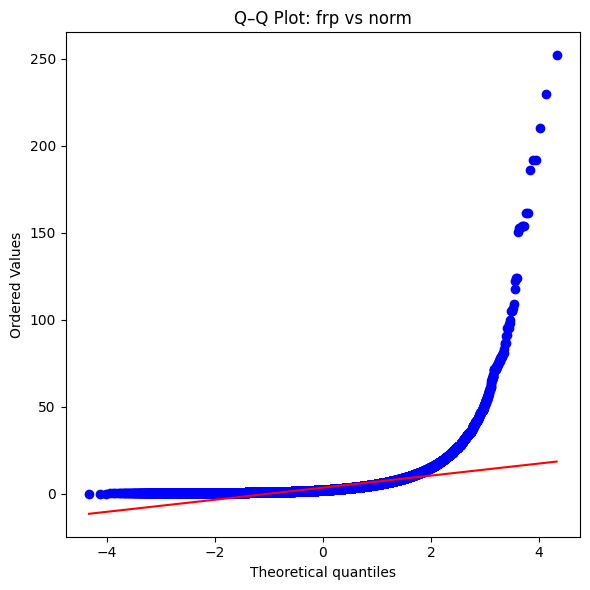

In [14]:
plot_qq(fire_df, "bright_ti4")
plot_qq(fire_df, "frp")

### Temporal analysis (fires per month)

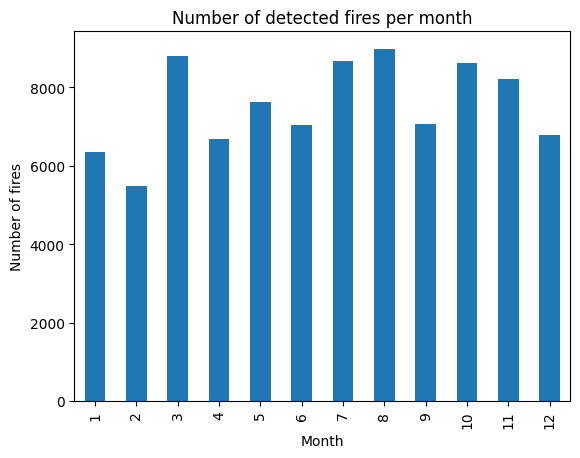

In [15]:
if "acq_date" in fire_df.columns:
    fire_df["date"] = pd.to_datetime(fire_df["acq_date"])
    fire_df["month"] = fire_df["date"].dt.month
    fire_df.groupby("month")["bright_ti4"].count().plot(kind='bar')
    plt.title("Number of detected fires per month")
    plt.xlabel("Month")
    plt.ylabel("Number of fires")
    plt.show()


### Geospatial Analysis (Spatial Patterns)

=== GeoDataFrame Info ===
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 90250 entries, 0 to 90249
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   latitude    90250 non-null  float64       
 1   longitude   90250 non-null  float64       
 2   bright_ti4  90250 non-null  float64       
 3   scan        90250 non-null  float64       
 4   track       90250 non-null  float64       
 5   acq_date    90250 non-null  object        
 6   acq_time    90250 non-null  int64         
 7   satellite   90250 non-null  object        
 8   instrument  90250 non-null  object        
 9   confidence  90250 non-null  object        
 10  bright_ti5  90250 non-null  float64       
 11  frp         90250 non-null  float64       
 12  daynight    90250 non-null  object        
 13  type        90250 non-null  int64         
 14  date        90250 non-null  datetime64[ns]
 15  month       90250 non-null  int32   

,latitude,longitude,bright_ti4,scan,track,acq_time,bright_ti5,frp,type,date,month
count,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250.000000,90250,90250.000000
mean,31.476760,6.280033,321.091793,0.475991,0.515446,380.331623,291.726092,3.447776,1.690936,2024-07-07 04:53:27.410526208,6.698139
min,19.603230,-8.118050,240.170000,0.320000,0.360000,0.000000,244.790000,0.060000,0.000000,2024-01-01 00:00:00,1.000000
25%,28.911510,5.642160,305.380000,0.400000,0.390000,59.000000,282.900000,1.150000,2.000000,2024-04-08 00:00:00,4.000000
50%,31.409125,6.557880,316.710000,0.450000,0.490000,140.000000,290.790000,2.060000,2.000000,2024-07-13 00:00:00,7.000000
75%,32.560313,8.083758,337.400000,0.540000,0.620000,232.000000,298.100000,3.920000,2.000000,2024-10-03 00:00:00,10.000000
max,37.323460,11.110350,367.000000,0.800000,0.780000,1410.000000,355.420000,251.890000,3.000000,2024-12-31 00:00:00,12.000000
std,2.666477,2.593748,18.205551,0.101596,0.126508,480.710563,11.700269,5.222111,0.735207,NaN,3.347426


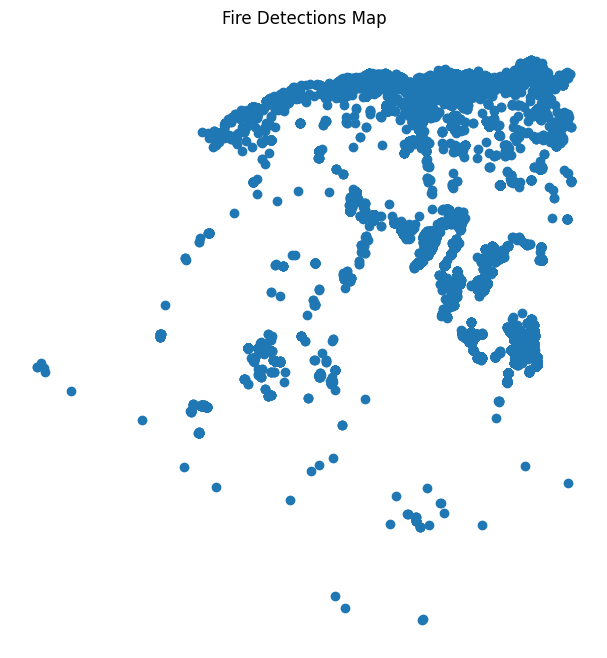

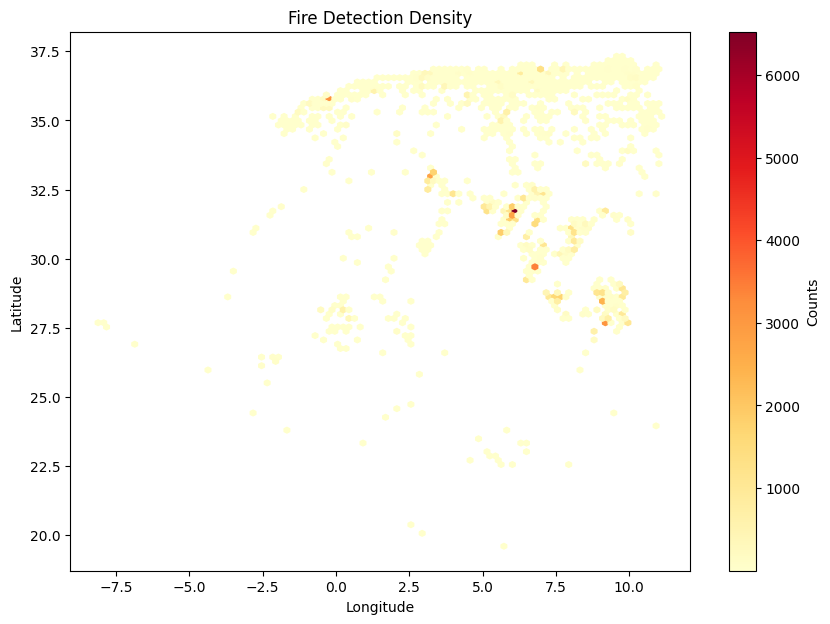

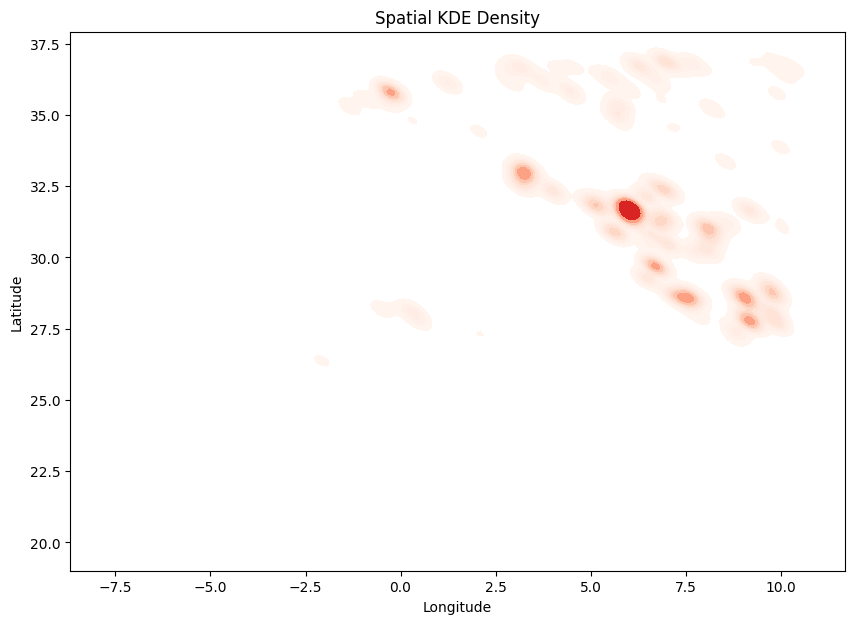

In [16]:
from shapely.geometry import Point
import geopandas as gpd
from eda_scripts.eda_utils import plot_geodata, summarize_geodata, plot_spatial_heatmap, plot_spatial_kde

fire_gdf = gpd.GeoDataFrame(
    fire_df,
    geometry=[Point(xy) for xy in zip(fire_df["longitude"], fire_df["latitude"])],
    crs="EPSG:4326"
)
summarize_geodata(fire_gdf)
plot_geodata(fire_gdf, title="Fire Detections Map")
plot_spatial_heatmap(fire_gdf, title="Fire Detection Density")
plot_spatial_kde(fire_gdf)


# 🌱 EDA for Soil Data 🌱

### General Dataset Overview

In [17]:
soil_features = [
    "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA",
    "TEXTURE_SOTER", "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER",
    "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT",
    "ALUM_SAT", "ESP", "TCARBON_EQ", "GYPSUM", "ELEC_COND"
]

soil_df = pd.read_csv("D1_soil_features_alg_tun.csv")
describe_dataset(soil_df)

=== 🧾 Dataset Preview ===


,HWSD2_SMU_ID,COARSE,SAND,SILT,CLAY,TEXTURE_USDA,TEXTURE_SOTER,BULK,REF_BULK,ORG_CARBON,...,CEC_SOIL,CEC_CLAY,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
0,31816,11,40,41,19,9.0,M,1.47,1.69,2.037,...,11,26,6.0,5.0,47,21,1,0.0,0.1,0
1,31801,11,40,41,19,9.0,M,1.47,1.69,2.037,...,11,26,6.0,5.0,47,21,1,0.0,0.1,0
2,31802,11,40,41,19,9.0,M,1.47,1.69,2.037,...,11,26,6.0,5.0,47,21,1,0.0,0.1,0
3,1694,7,89,5,6,12.0,C,1.39,1.34,0.242,...,4,47,5.0,4.0,89,0,2,4.4,0.1,0
4,32050,9,88,6,6,12.0,C,1.62,1.34,0.255,...,5,52,12.0,12.0,100,0,2,5.8,0.1,0



=== ℹ️ General Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HWSD2_SMU_ID   861 non-null    int64  
 1   COARSE         861 non-null    int64  
 2   SAND           861 non-null    int64  
 3   SILT           861 non-null    int64  
 4   CLAY           861 non-null    int64  
 5   TEXTURE_USDA   842 non-null    float64
 6   TEXTURE_SOTER  861 non-null    object 
 7   BULK           861 non-null    float64
 8   REF_BULK       842 non-null    float64
 9   ORG_CARBON     861 non-null    float64
 10  PH_WATER       861 non-null    float64
 11  TOTAL_N        861 non-null    float64
 12  CN_RATIO       861 non-null    float64
 13  CEC_SOIL       861 non-null    int64  
 14  CEC_CLAY       861 non-null    int64  
 15  CEC_EFF        861 non-null    float64
 16  TEB            861 non-null    float64
 17  BSAT           861 non

,HWSD2_SMU_ID,COARSE,SAND,SILT,CLAY,TEXTURE_USDA,BULK,REF_BULK,ORG_CARBON,PH_WATER,...,CEC_SOIL,CEC_CLAY,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
count,861.000000,861.000000,861.000000,861.000000,861.000000,842.000000,861.000000,842.000000,861.000000,861.000000,...,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000
mean,20187.623693,11.787456,46.955865,29.397213,21.203252,8.963183,1.318780,1.714905,0.830069,7.449129,...,15.344948,58.126597,36.076655,35.135889,91.348432,0.421603,6.811847,9.072125,4.345064,2.096400
std,14818.508224,10.006283,16.134836,9.079760,10.372562,2.430450,0.780874,0.132114,0.968955,1.803727,...,7.651307,17.204894,23.647827,24.236123,18.310991,3.396640,13.743308,6.942119,10.999932,4.527821
min,36.000000,-9.000000,-9.000000,-9.000000,-9.000000,3.000000,-9.000000,1.200000,-9.000000,-9.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,1800.000000,4.000000,40.000000,26.000000,16.000000,9.000000,1.370000,1.650000,0.589000,7.400000,...,13.000000,48.000000,23.000000,20.000000,93.000000,0.000000,2.000000,4.200000,0.300000,1.000000
50%,31844.000000,9.000000,47.000000,30.000000,20.000000,9.000000,1.440000,1.710000,0.697000,8.000000,...,14.000000,61.000000,31.000000,31.000000,99.000000,0.000000,3.000000,8.900000,0.600000,1.000000
75%,31931.000000,18.000000,55.000000,36.000000,24.000000,11.000000,1.470000,1.780000,1.136000,8.200000,...,17.000000,71.000000,38.000000,38.000000,100.000000,0.000000,4.000000,12.900000,3.300000,1.000000
max,32050.000000,46.000000,90.000000,53.000000,55.000000,12.000000,1.760000,2.040000,7.326000,8.600000,...,41.000000,83.000000,143.000000,143.000000,100.000000,40.000000,67.000000,31.299999,57.599998,32.000000


### Check for Missing Values

In [19]:
missing_value = check_missing_values(soil_df[soil_features])

⚠️ Missing values detected:


TEXTURE_USDA    2.206736
REF_BULK        2.206736
dtype: float64

### Visualize Missing Values

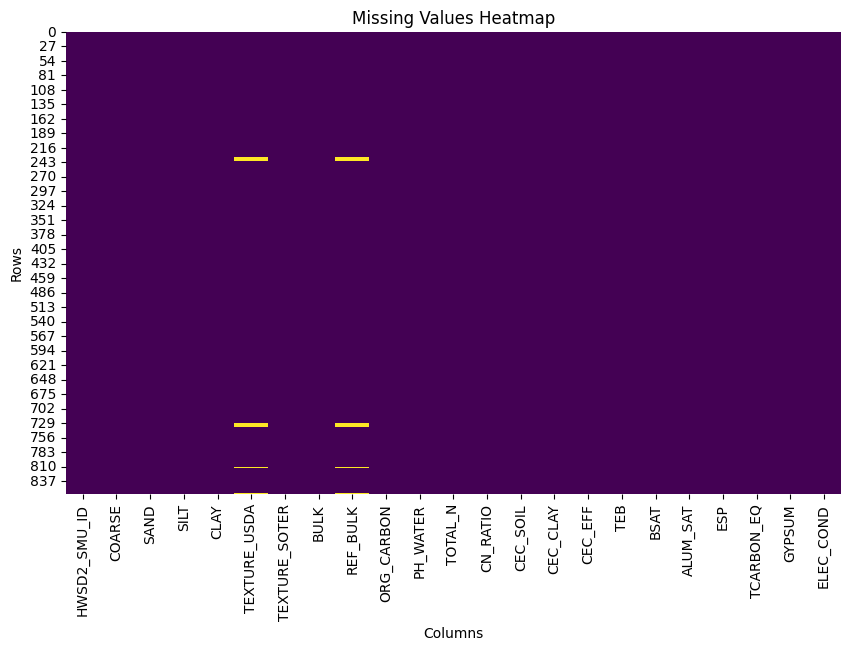

In [20]:
plot_missing_values(soil_df)

### Statistics and Data Quality Report

In [23]:

data_quality_report(soil_df[soil_features])
print(summary_stats(soil_df, [c for c in soil_features if c not in ["TEXTURE_USDA", "TEXTURE_SOTER"]]))


=== Data Quality Report ===


,Data Type,Missing (%),Unique Values,Zeros (%),Negative Values (%)
REF_BULK,float64,2.206736,41,0.000000,0.000000
TEXTURE_USDA,float64,2.206736,7,0.000000,0.000000
BULK,float64,0.000000,47,0.000000,2.206736
CEC_CLAY,int64,0.000000,46,0.000000,2.206736
ALUM_SAT,int64,0.000000,17,94.657375,2.206736
BSAT,int64,0.000000,36,0.000000,2.206736
CEC_SOIL,int64,0.000000,34,0.000000,2.206736
CEC_EFF,float64,0.000000,52,0.000000,2.206736
CLAY,int64,0.000000,37,0.000000,2.206736
CN_RATIO,float64,0.000000,15,0.000000,2.206736


            COARSE        SAND        SILT        CLAY        BULK  \
mean     11.787456   46.955865   29.397213   21.203252    1.318780   
median    9.000000   47.000000   30.000000   20.000000    1.440000   
std      10.006283   16.134836    9.079760   10.372562    0.780874   
min      -9.000000   -9.000000   -9.000000   -9.000000   -9.000000   
max      46.000000   90.000000   53.000000   55.000000    1.760000   
count   861.000000  861.000000  861.000000  861.000000  861.000000   

          REF_BULK  ORG_CARBON    PH_WATER     TOTAL_N    CN_RATIO  \
mean      1.714905    0.830069    7.449129    0.859988    9.674797   
median    1.710000    0.697000    8.000000    0.830000    9.000000   
std       0.132114    0.968955    1.803727    0.829038    2.503705   
min       1.200000   -9.000000   -9.000000   -9.000000   -9.000000   
max       2.040000    7.326000    8.600000    3.690000   24.000000   
count   842.000000  861.000000  861.000000  861.000000  861.000000   

          CEC_SOIL

### Distribution, Outlier & Relationship Visuals

Histograms

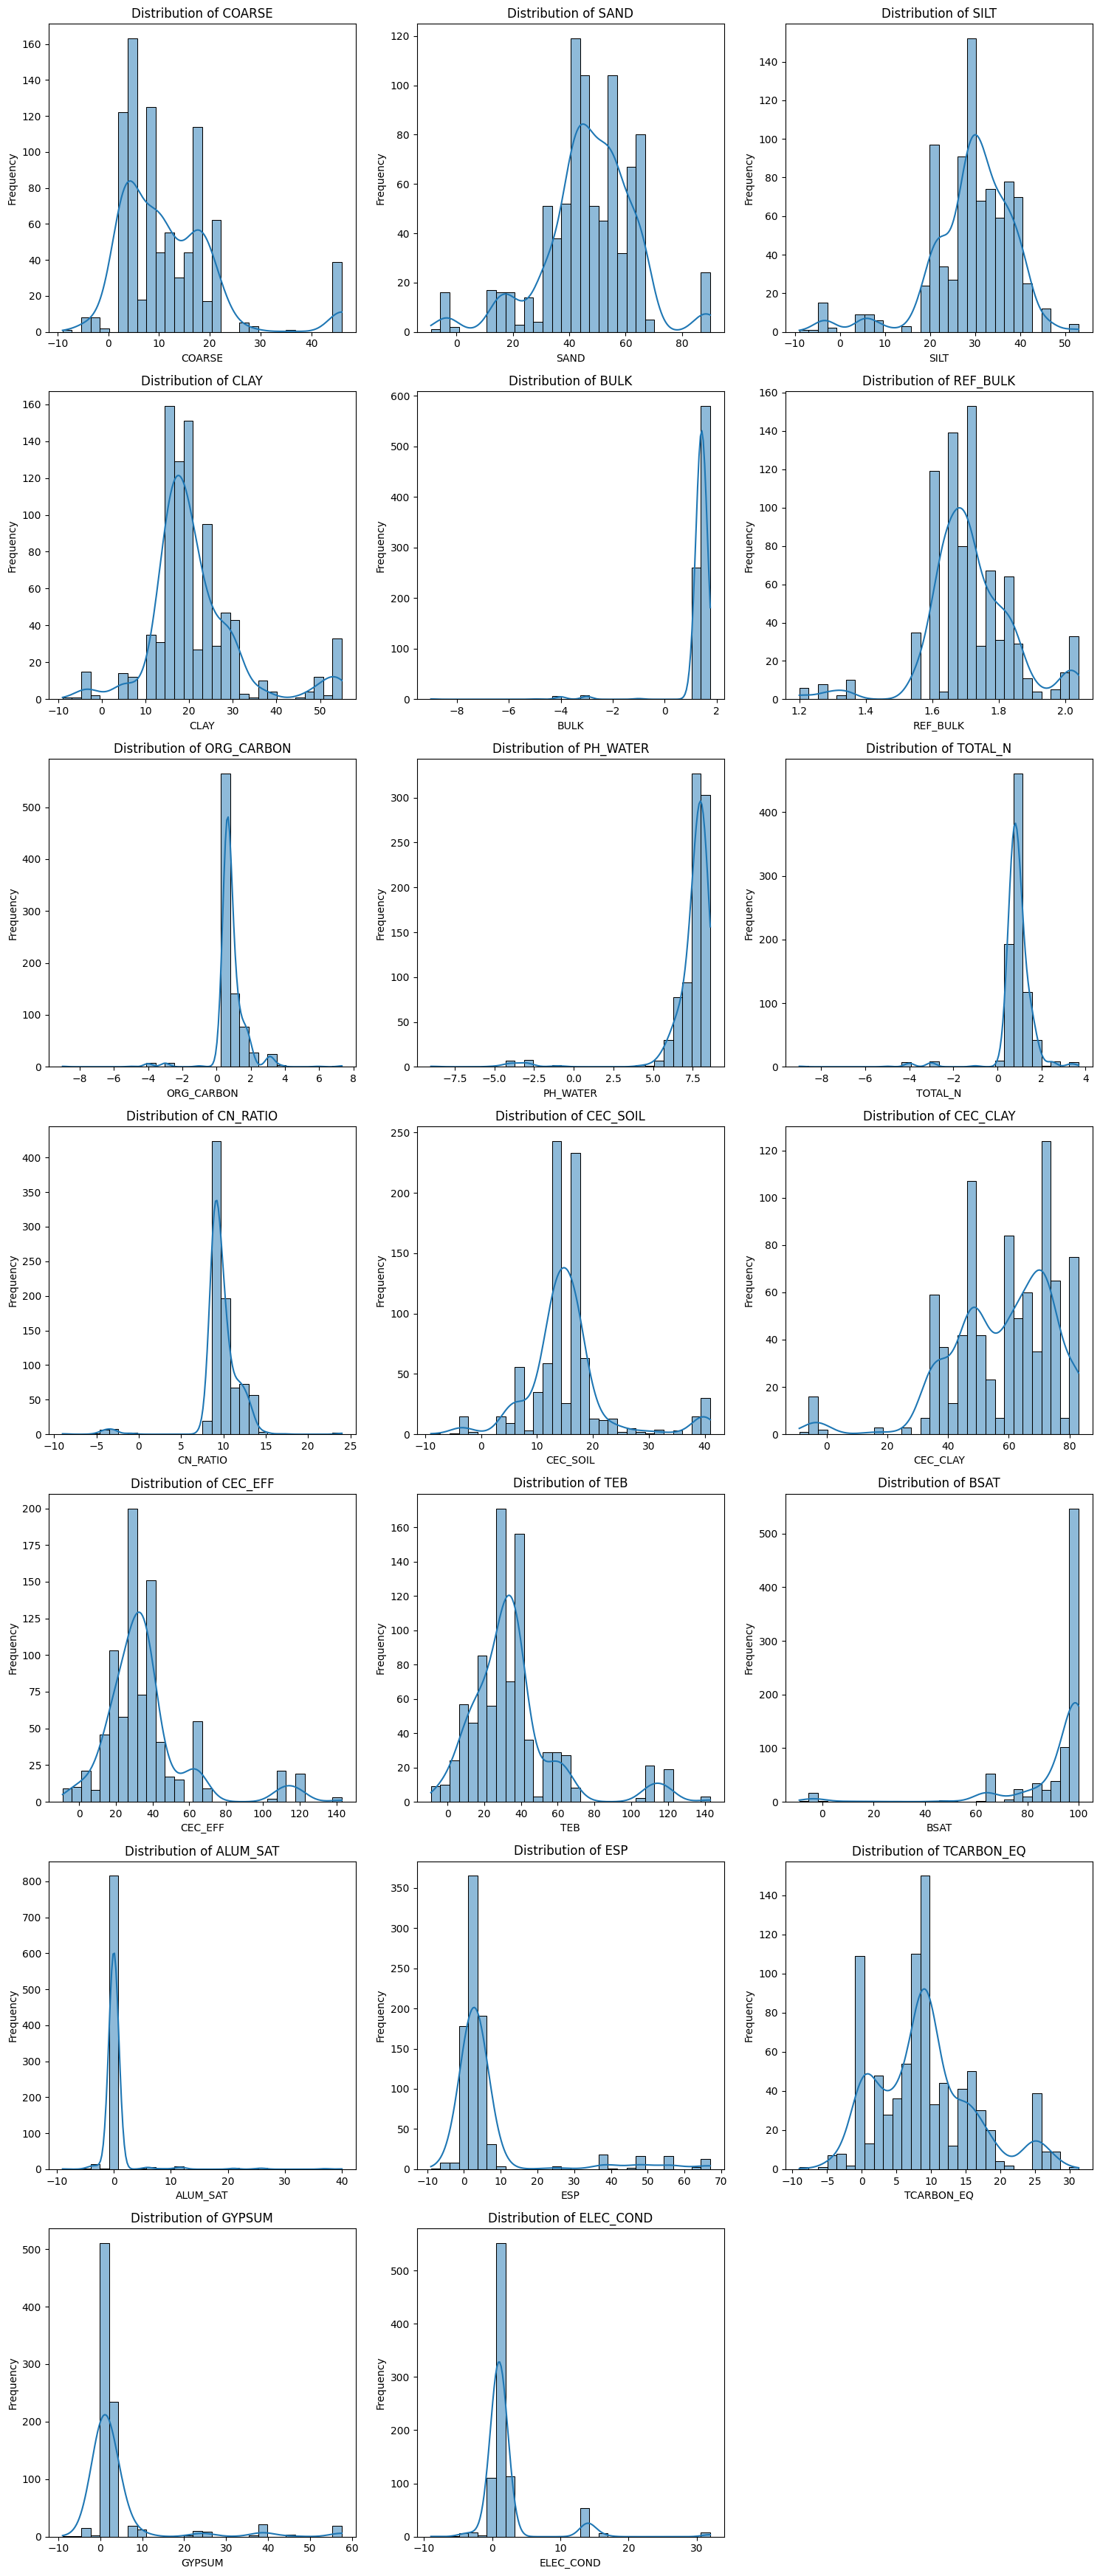

In [24]:
plot_multiple_distributions(soil_df, [c for c in soil_features if c not in ["TEXTURE_USDA", "TEXTURE_SOTER"]], bins=30)

Boxplots & Outliers

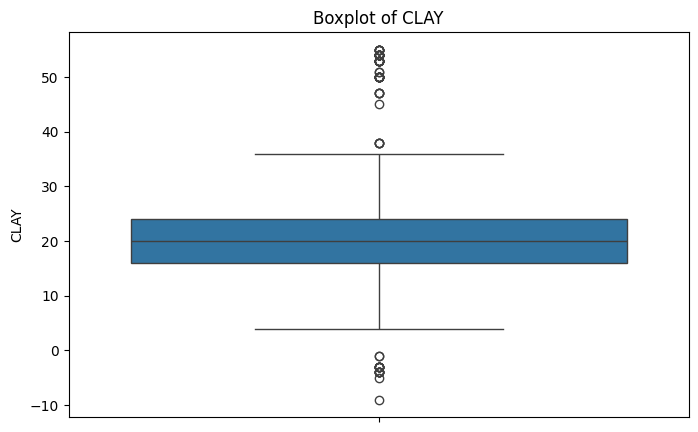

=== Outlier Detection Report for 'CLAY' ===
Q1 (25th percentile): 16.0000
Q2 (Median):          20.0000
Q3 (75th percentile): 24.0000
IQR (Q3 - Q1):        8.0000
Lower bound:          4.0000
Upper bound:          36.0000
Number of outliers:   75 / 861 rows


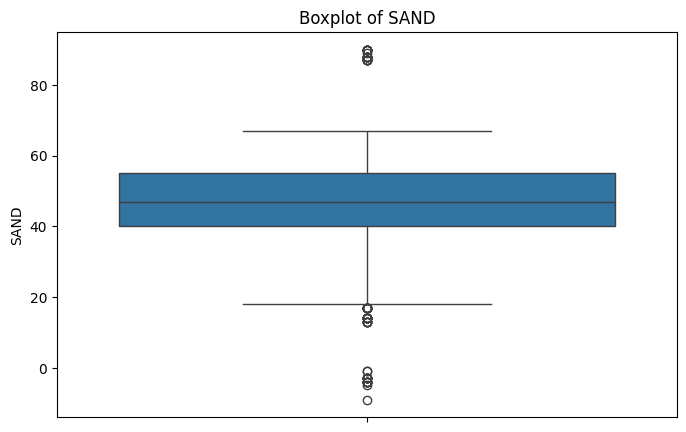

=== Outlier Detection Report for 'SAND' ===
Q1 (25th percentile): 40.0000
Q2 (Median):          47.0000
Q3 (75th percentile): 55.0000
IQR (Q3 - Q1):        15.0000
Lower bound:          17.5000
Upper bound:          77.5000
Number of outliers:   76 / 861 rows


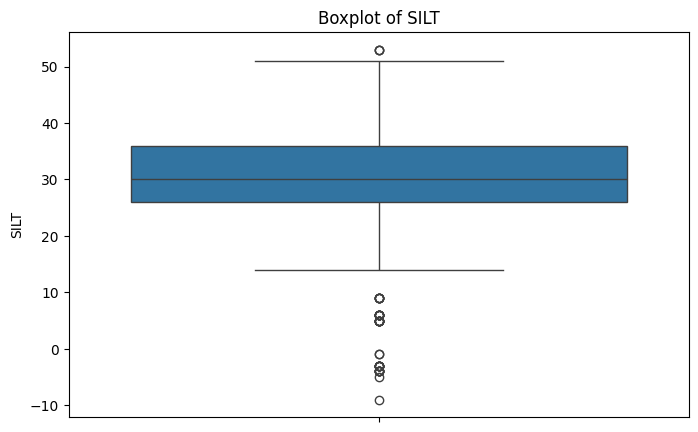

=== Outlier Detection Report for 'SILT' ===
Q1 (25th percentile): 26.0000
Q2 (Median):          30.0000
Q3 (75th percentile): 36.0000
IQR (Q3 - Q1):        10.0000
Lower bound:          11.0000
Upper bound:          51.0000
Number of outliers:   46 / 861 rows


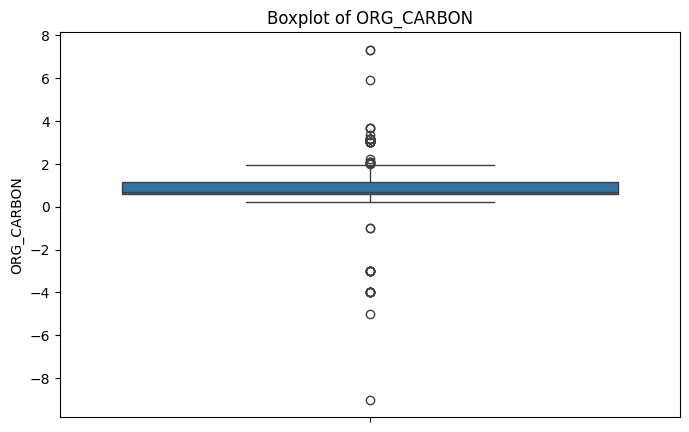

=== Outlier Detection Report for 'ORG_CARBON' ===
Q1 (25th percentile): 0.5890
Q2 (Median):          0.6970
Q3 (75th percentile): 1.1360
IQR (Q3 - Q1):        0.5470
Lower bound:          -0.2315
Upper bound:          1.9565
Number of outliers:   57 / 861 rows


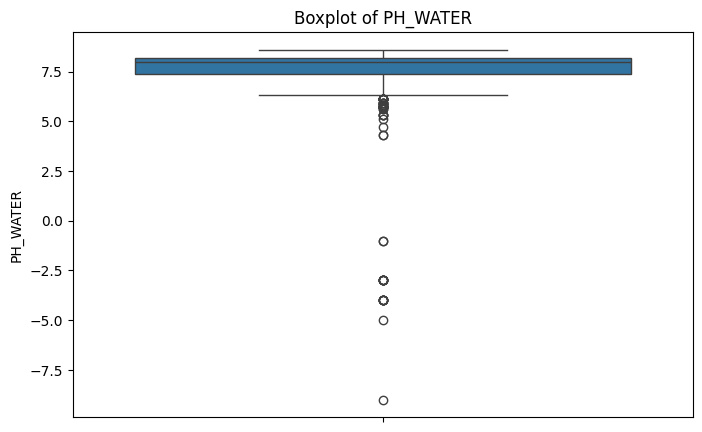

=== Outlier Detection Report for 'PH_WATER' ===
Q1 (25th percentile): 7.4000
Q2 (Median):          8.0000
Q3 (75th percentile): 8.2000
IQR (Q3 - Q1):        0.8000
Lower bound:          6.2000
Upper bound:          9.4000
Number of outliers:   59 / 861 rows


In [25]:
for col in ["CLAY", "SAND", "SILT", "ORG_CARBON", "PH_WATER"]:
    plot_boxplot(soil_df, col)
    detect_outliers_iqr(soil_df, col)

Skewness & Kurtosis

In [26]:

report_skew_kurtosis(soil_df, [c for c in soil_features if c not in ["TEXTURE_USDA", "TEXTURE_SOTER"]])


COARSE: skew=1.69, kurtosis=3.72
SAND: skew=-0.50, kurtosis=1.56
SILT: skew=-1.25, kurtosis=2.96
CLAY: skew=1.27, kurtosis=3.13
BULK: skew=-7.51, kurtosis=64.31
REF_BULK: skew=-0.33, kurtosis=2.76
ORG_CARBON: skew=-1.65, kurtosis=25.19
PH_WATER: skew=-5.43, kurtosis=32.81
TOTAL_N: skew=-4.57, kurtosis=38.50
CN_RATIO: skew=-2.70, kurtosis=19.21
CEC_SOIL: skew=1.33, kurtosis=3.97
CEC_CLAY: skew=-1.00, kurtosis=1.78
CEC_EFF: skew=1.97, kurtosis=5.00
TEB: skew=1.87, kurtosis=4.60
BSAT: skew=-3.66, kurtosis=14.97
ALUM_SAT: skew=7.81, kurtosis=70.67
ESP: skew=3.17, kurtosis=8.99
TCARBON_EQ: skew=0.61, kurtosis=0.27
GYPSUM: skew=3.61, kurtosis=12.72
ELEC_COND: skew=3.93, kurtosis=18.50


### Correlation and Pairwise Relationships

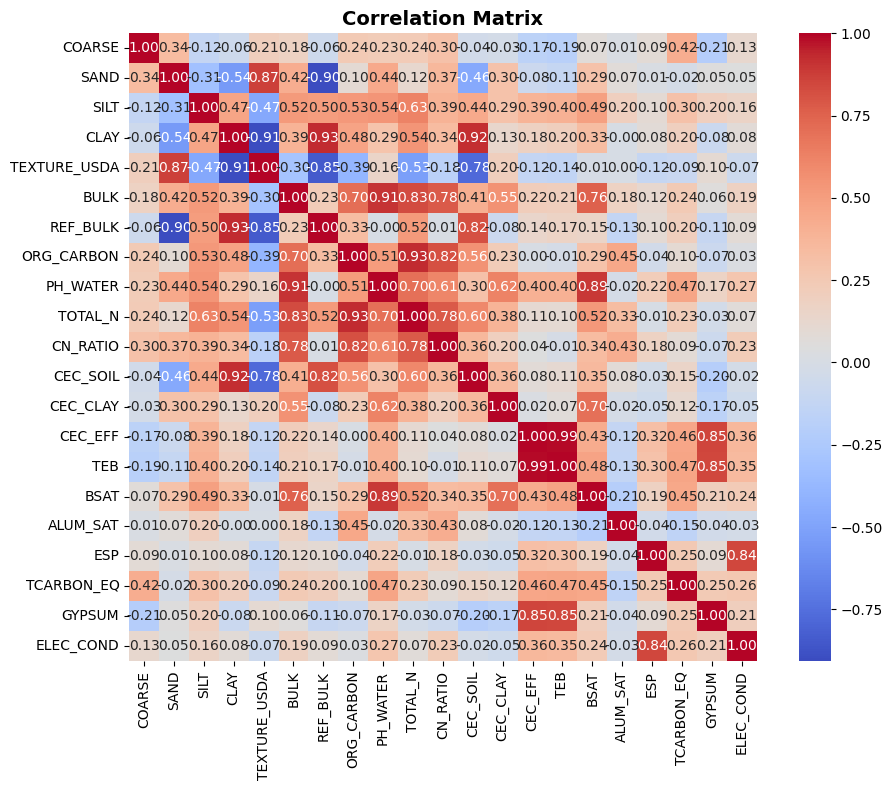

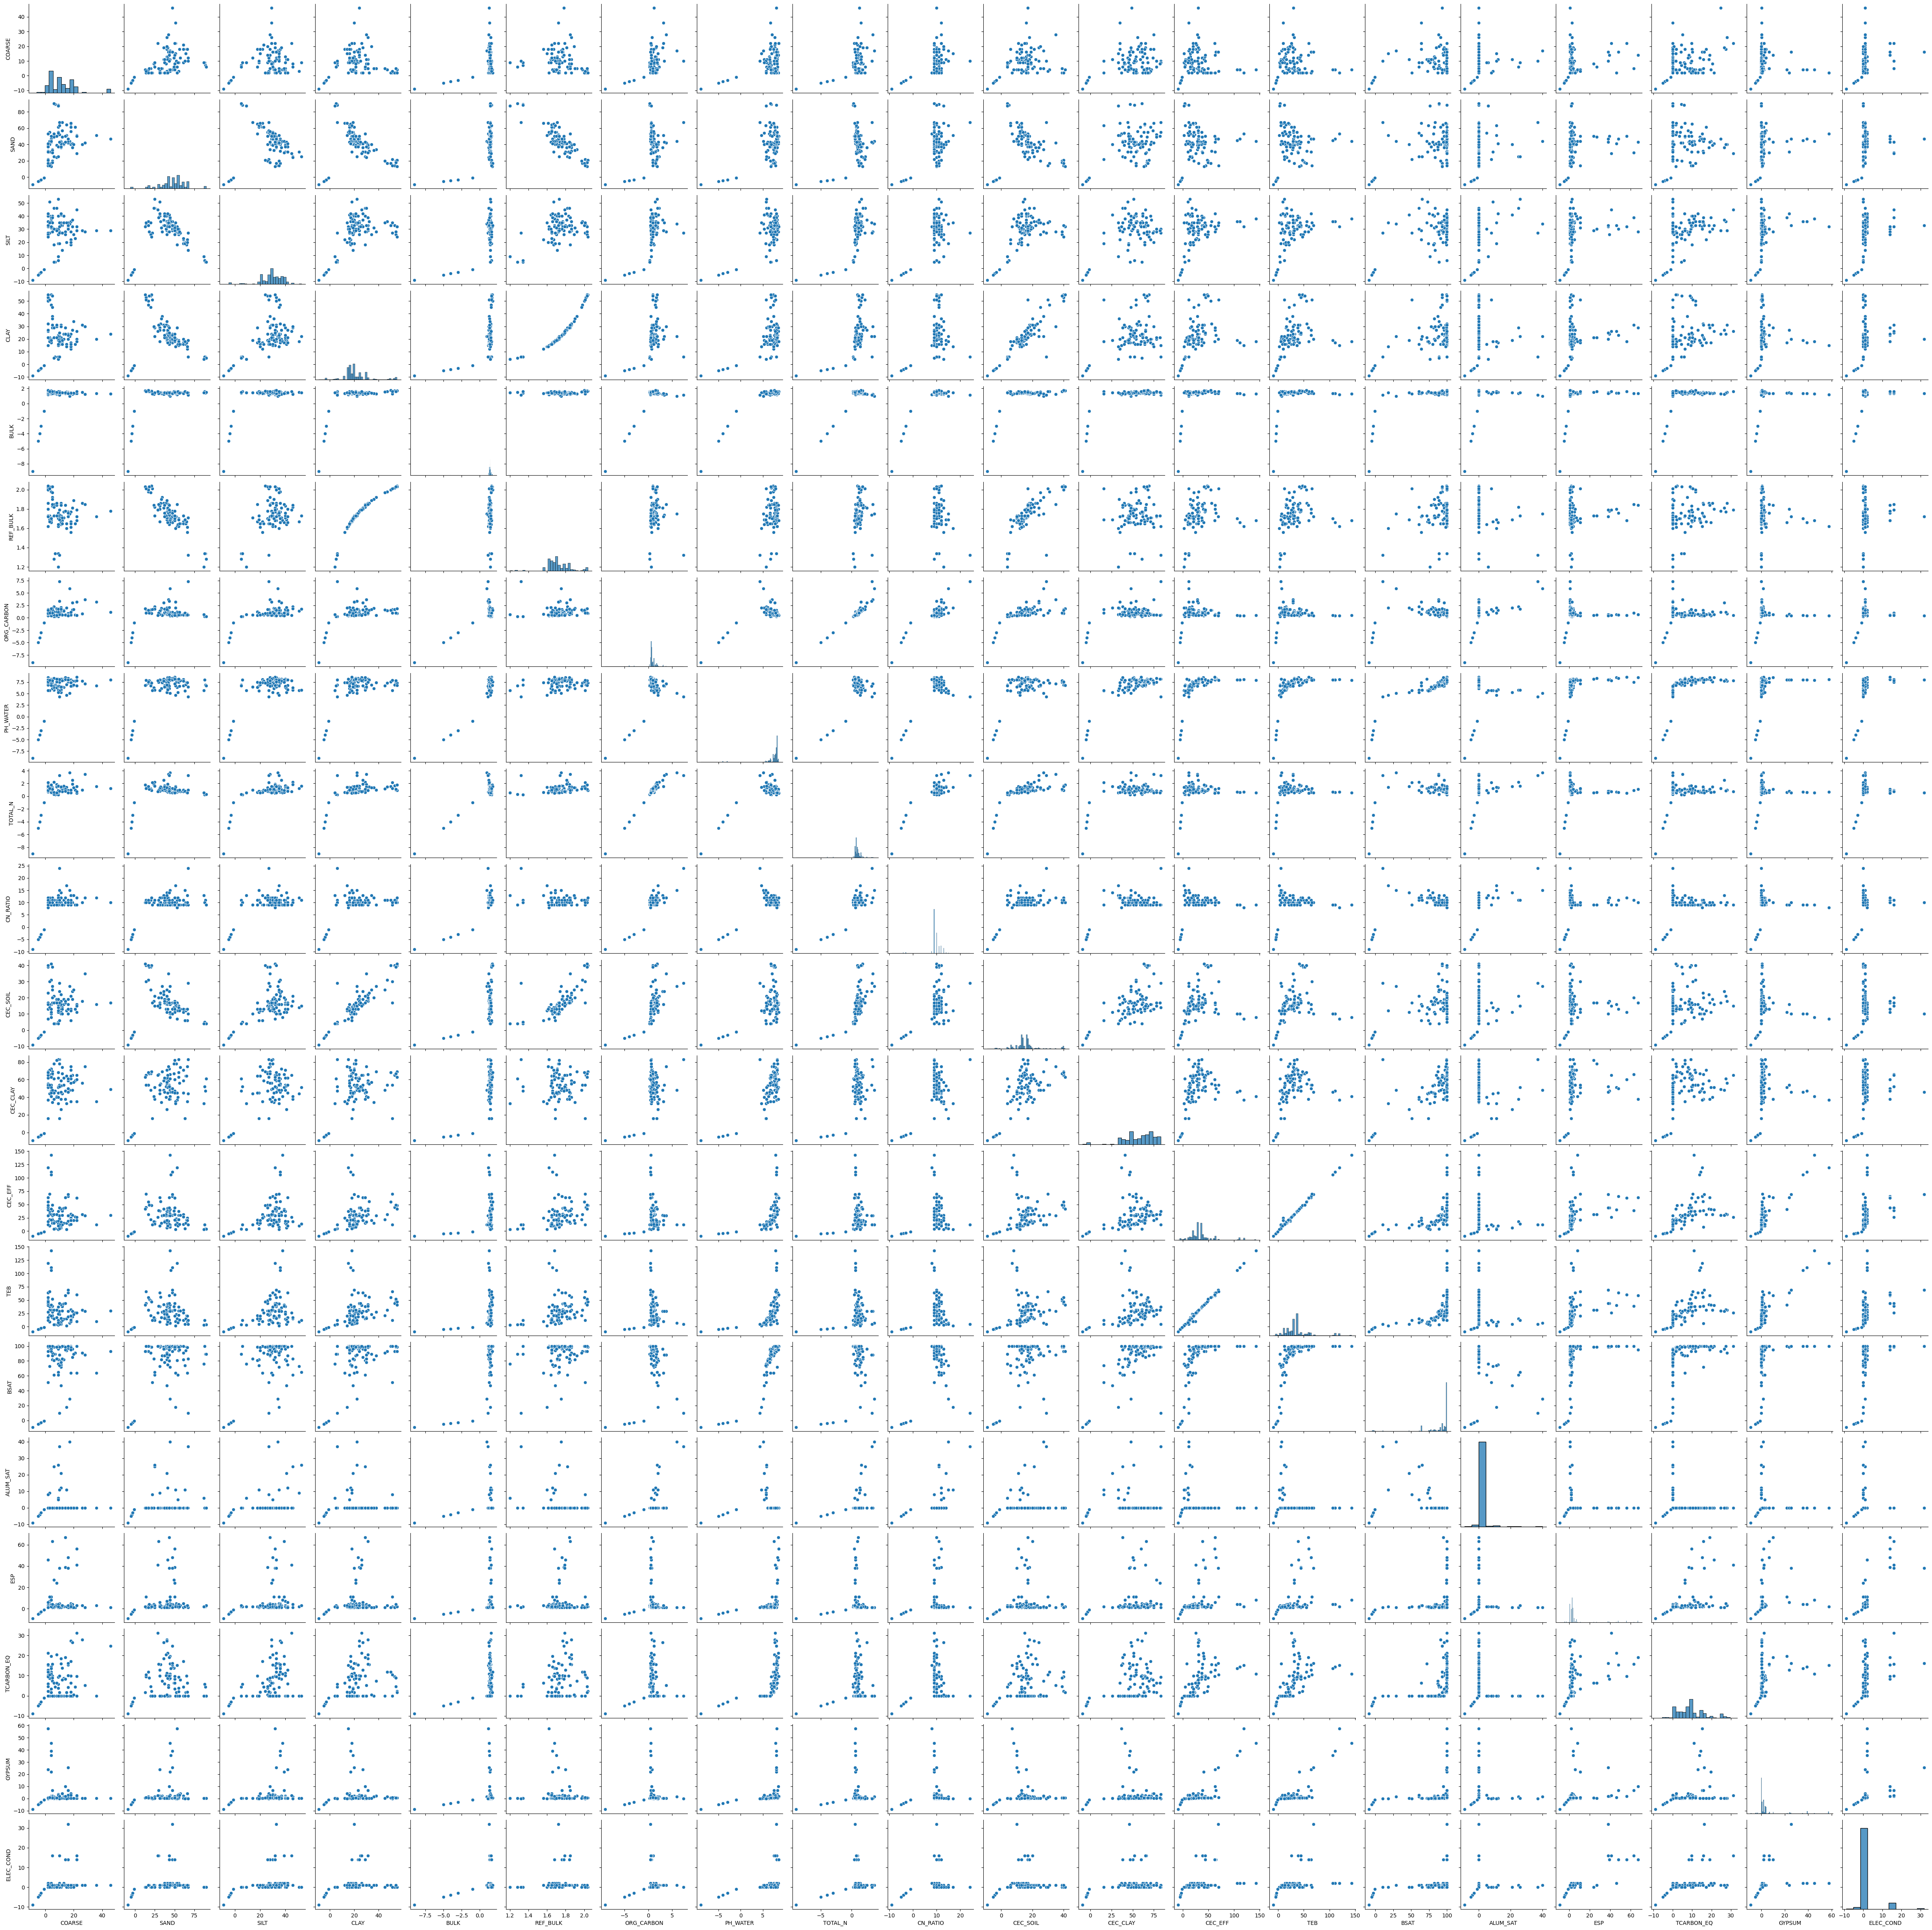

In [27]:

plot_correlation_matrix(soil_df[soil_features])
plot_pairplot(soil_df, columns=[c for c in soil_features if c not in ["TEXTURE_USDA", "TEXTURE_SOTER"]])


### Relationships

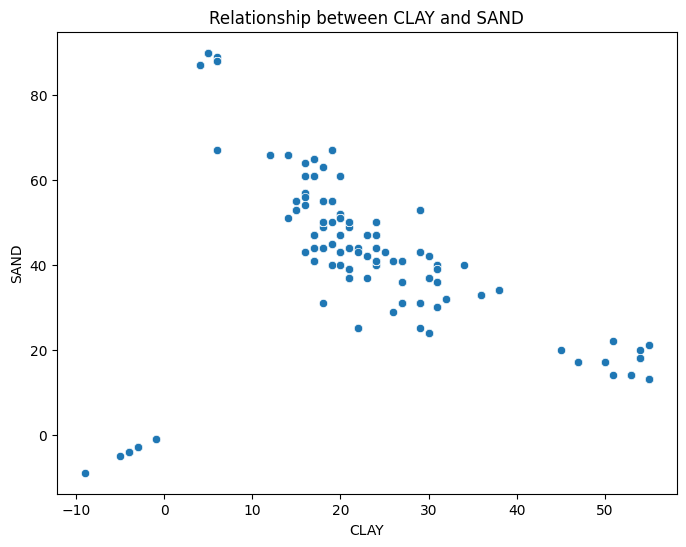

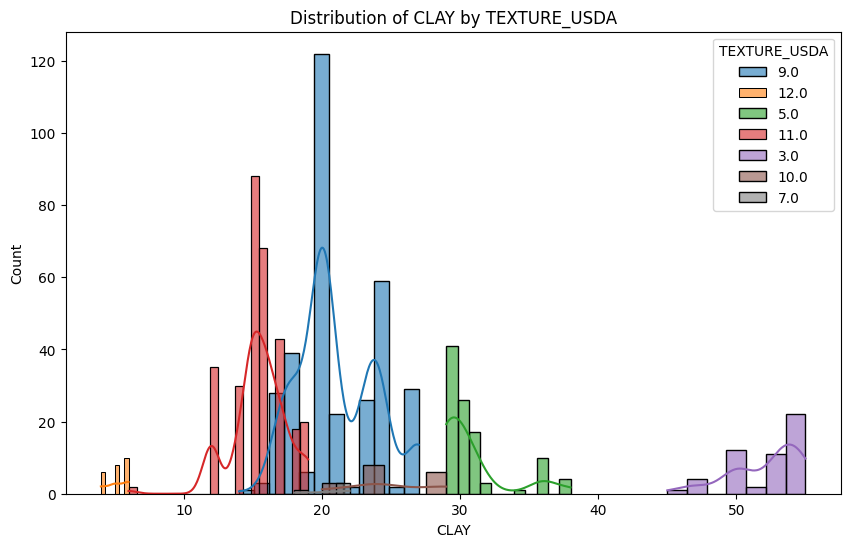

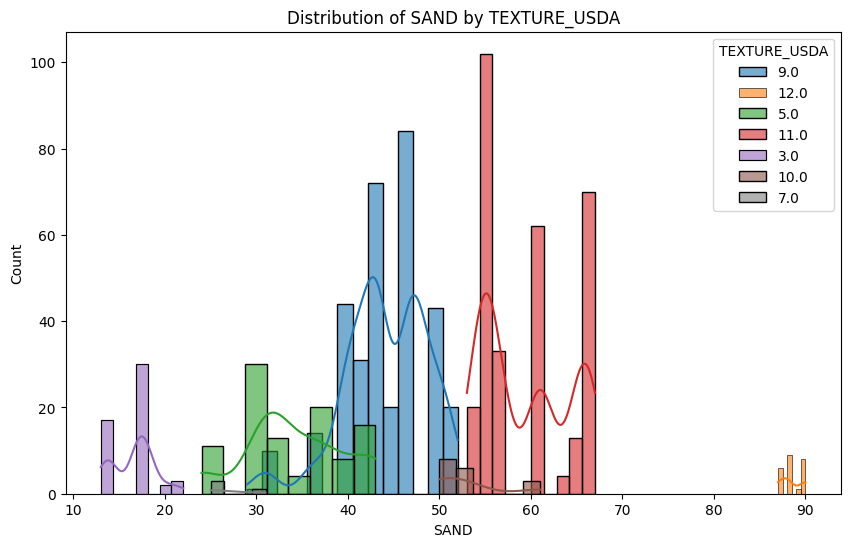

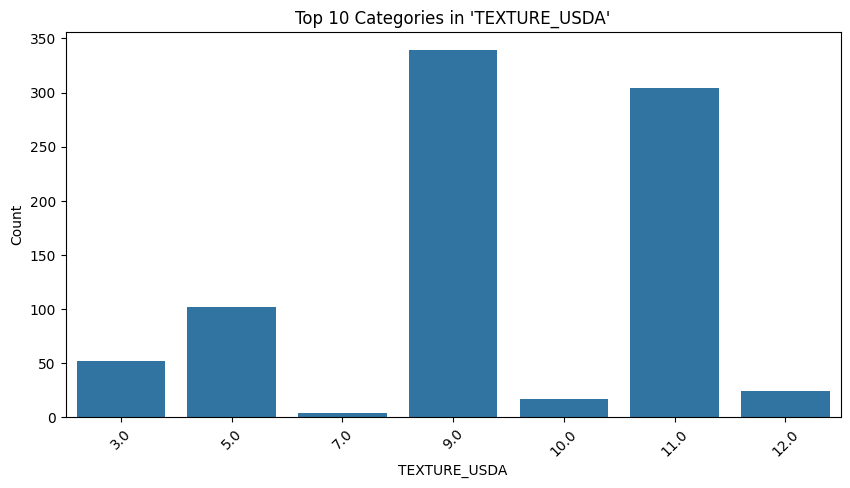

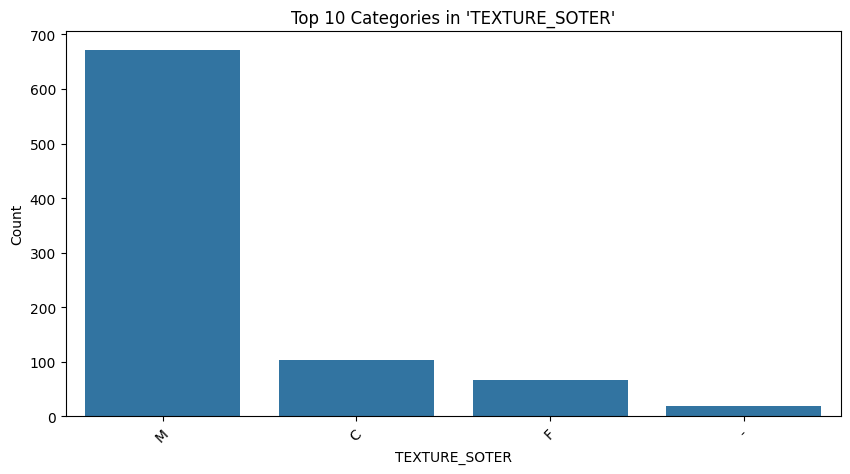

In [28]:
# Quantitative relationship
plot_scatter(soil_df, "CLAY", "SAND")

# Distribution per class
compare_distributions(soil_df, "CLAY", by="TEXTURE_USDA")
compare_distributions(soil_df, "SAND", by="TEXTURE_USDA")
plot_categorical_distribution(soil_df, "TEXTURE_USDA", top_n=10)
plot_categorical_distribution(soil_df, "TEXTURE_SOTER", top_n=10)

### Q–Q Plot

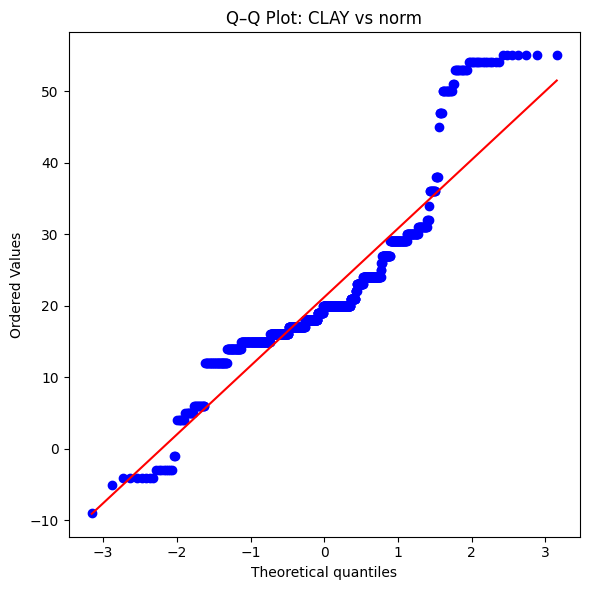

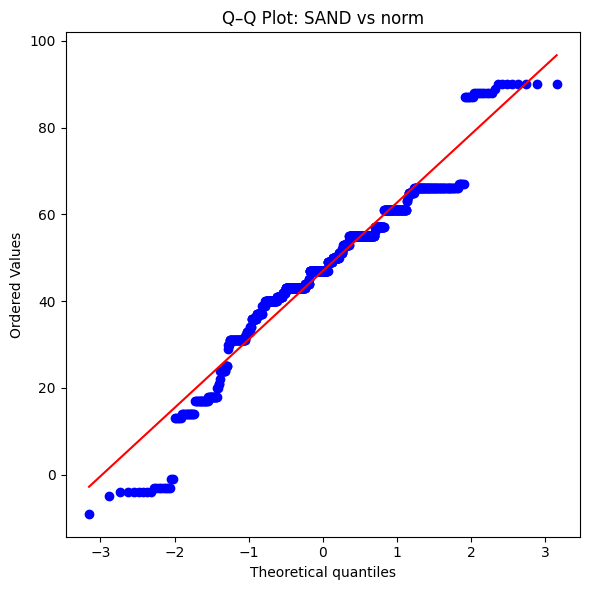

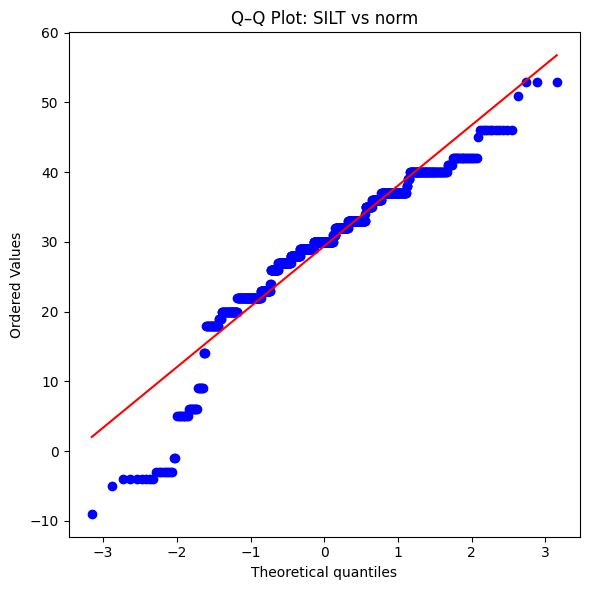

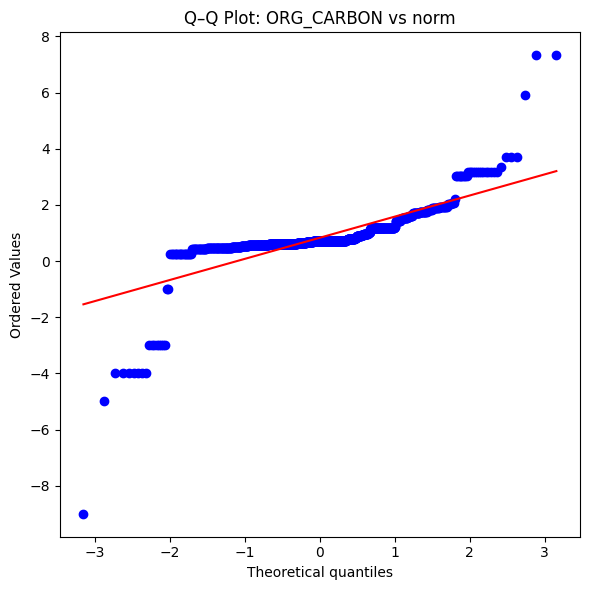

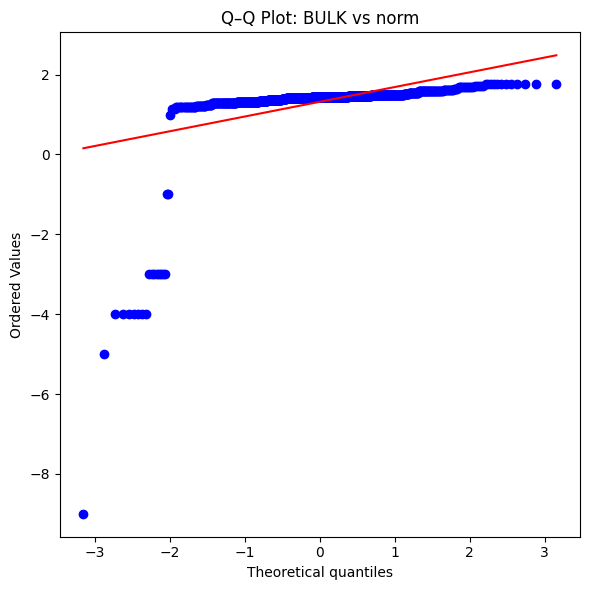

In [29]:
for col in ["CLAY", "SAND", "SILT", "ORG_CARBON", "BULK"]:
    plot_qq(soil_df, col)